In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tqdm
import h5py
import torch
from torch.utils.data import DataLoader
from dataloader_video import VideoCLIPDataset

import math
import urllib.request
import clip
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms

In [4]:
frame_num = 32
dataset = VideoCLIPDataset(None, frame_num, "/home/disk2/dachuang1-23/kafka_result/399/*.mp4")  # 加载视频文件
# dataset = VideoCLIPDataset(None, frame_num, "C:/Users/xiwei/Desktop/1/*.mp4")  # 加载视频文件

print(len(dataset))

dataloader = DataLoader(
    dataset,
    batch_size=1, # 每次加载 1 个样本
    num_workers = 2,
    shuffle=False
)
data_iter = iter(dataloader)

0


In [5]:
# Load CLIP model.
# 指定加载的 CLIP 模型类型
clip_model = "ViT-B/32" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

## Extract Feature

In [6]:
# dataset_feats = h5py.File("/home/disk2/dachuang1-23/kafka_result/399/clip_patch_feat_all.h5", "w")
dataset_feats = h5py.File("C:/Users/xiwei/Desktop/1/clip_patch_feat_all.h5", "w")

dataset_feats.create_dataset("features", (len(dataset), 32, 17, 512))
dataset_feats.create_dataset("ids", (len(dataset), ), 'S20')
# dataset_feats.close()

<HDF5 dataset "ids": shape (0,), type "|S20">

In [7]:
# 从数据加载器 dataloader 中提取每个视频帧的图像特征，并将这些特征和视频 ID 保存到之前创建的 HDF5 文件（dataset_feats）中
global_index = 0
video_ids = {}
data_iter = iter(dataloader)
for batch in tqdm.tqdm(data_iter):
    batch_size = batch['video'].shape[0]
    for i in range(batch_size):
        for j in range(frame_num):
            with torch.no_grad():  
                image_features = model.encode_image(batch['video'][i][j].cuda())
            dataset_feats['features'][global_index, j] = image_features.detach().cpu().numpy()
        dataset_feats['ids'][global_index] = batch['vid'][i].encode("ascii", "ignore")  
        global_index += 1

0it [00:05, ?it/s]


In [8]:
dataset_feats.close()

## Check Results

In [9]:
# batch = data_iter.next()

In [10]:
# Load CLIP model.
clip_model = "ViT-B/32" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

In [11]:
# 图像预处理、特征提取、以及图像块的可视化
def load_image(raw_img, resize=None, pil=False):
    if isinstance(raw_img, str):
        image = Image.open(raw_img).convert("RGB")
    else:
        image = Image.fromarray(raw_img).convert("RGB")
    
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

# 用于可视化图像块（patches），并可以标注特定的块
def viz_patches(x, figsize=(20, 20), patch_idx=None, topk=None, t=5, save_path):
    # x: num_patches, 3, patch_size, patch_size
    n = x.shape[0]
    nrows = int(math.sqrt(n))
    _, axes = plt.subplots(nrows, nrows, figsize=figsize)

    # 如果有子图的数量小于总补丁数量，调整布局
    if len(axes.flatten()) < n:
        axes = axes.flatten()
        extra_axes = len(axes.flatten()) - n
        for _ in range(extra_axes):
            axes[-1].axis('off')

    for i, ax in enumerate(axes.flatten()):            
        im = x[i].permute(1, 2, 0).numpy()
        im = (im * 255.).round().astype(np.uint8)
        if patch_idx is not None and i == patch_idx:
            im[0:t] = (255, 0, 0)
            im[im.shape[0]-t:] = (255, 0, 0)
            im[:, 0:t] = (255, 0, 0)
            im[:, im.shape[1]-t:] = (255, 0, 0)
        if topk is not None:
            if i in topk and i != patch_idx:
                im[0:t] = (255, 255, 0)
                im[im.shape[0]-t:] = (255, 255, 0)
                im[:, 0:t] = (255, 255, 0)
                im[:, im.shape[1]-t:] = (255, 255, 0)
        ax.imshow(im)
        ax.axis("off")
    plt.show()
    if save_path is not None:
        plt.savefig(save_path)  # 保存图像到文件
    plt.close()  # 关闭当前图形

# 将图像切分成多个小块（patches），并返回这些小块。
def patchify(image_path, resolution, patch_size, patch_stride=None):
    img_tensor = transforms.ToTensor()(load_image(image_path, resolution, True))
    if patch_stride is None:
        patch_stride = patch_size
    patches = img_tensor.unfold(
        1, patch_size, patch_stride).unfold(2, patch_size, patch_stride)
    patches = patches.reshape(3, -1, patch_size, patch_size).permute(1, 0, 2, 3)
    return patches  # N, 3, patch_size, patch_size

In [12]:
# 从图像中提取图像块（patches），并进行可视化
image_resolution = 224 * 4
patch_size = 224
image_index = 0
one_frame = batch['raw_frame'][0][image_index].permute(1,2,0).numpy()
raw_patches = patchify(one_frame, image_resolution, patch_size, patch_stride=None)
print("patches: ", raw_patches.shape)
viz_patches(raw_patches, figsize=(8, 8), save_path="C:/Users/xiwei/Desktop/1/output_patches1.png")

NameError: name 'batch' is not defined

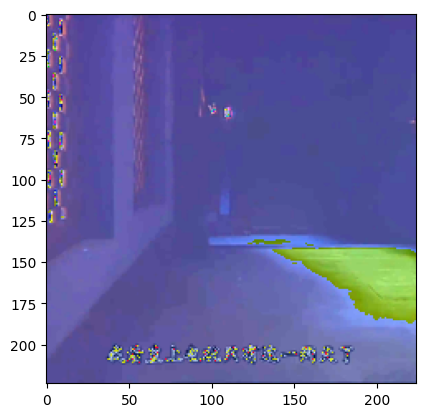

In [27]:
plt.imshow((batch['video'][0][image_index][0].permute(1, 2, 0).numpy() * 255.).round().astype(np.uint8))
plt.show()

# image = (batch['video'][0][image_index][0].permute(1, 2, 0).numpy() * 255.).round().astype(np.uint8)
# # 使用 imshow 显示图像
# plt.imshow(image)
# # 保存图像到文件
# save_path = 'C:/Users/xiwei/Desktop/1/output_patches2.png'
# plt.savefig(save_path)
# # 显示图像
# plt.show()
# # 关闭图形
# plt.close()

In [13]:
#@title Detect
patches = batch['video'][0][image_index][1:]

clip_model = "ViT-B/32" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
image_caption = 'green bottle' #@param {type:"string"}
topk =  4#@param {type:"integer"}

text_input = clip.tokenize([image_caption]).to(device)

patches_pad = patches.to(device)

with torch.no_grad():
    patch_embs = model.encode_image(patches_pad)
    text_embs, _ = model.encode_text(text_input)
    patch_embs = patch_embs / patch_embs.norm(dim=-1, keepdim=True)
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
    sim = patch_embs @ text_embs.t()
    idx_max = sim.argmax().item()
    topk_idxs = torch.topk(sim.flatten(), topk)[-1].cpu().numpy().tolist()

viz_patches(patches, figsize=(10, 10), patch_idx=idx_max, topk=topk_idxs, t=int(0.05*patch_size),save_path="C:/Users/xiwei/Desktop/1/output_patches3.png")

NameError: name 'batch' is not defined

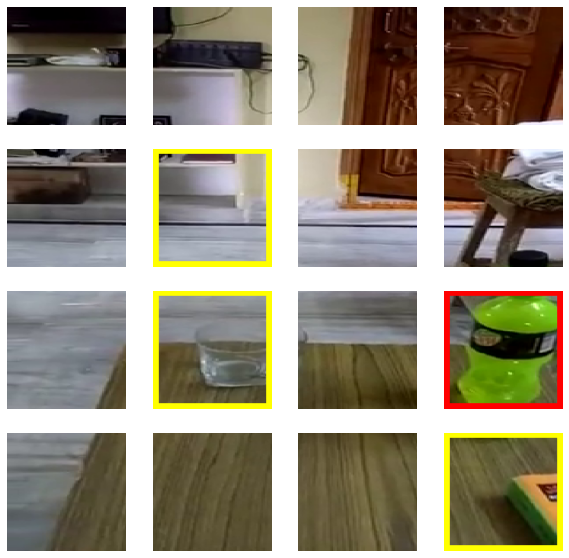

In [13]:
#@title Detect
patches = patchify(one_frame, image_resolution, patch_size, patch_stride=None)


# image_caption = 'hand' #@param {type:"string"}
topk =  4#@param {type:"integer"}

text_input = clip.tokenize([image_caption]).to(device)

patches_pad = patches.to(device)

with torch.no_grad():
    patch_embs = model.encode_image(patches_pad)
    text_embs, _ = model.encode_text(text_input)
    patch_embs = patch_embs / patch_embs.norm(dim=-1, keepdim=True)
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
    sim = patch_embs @ text_embs.t()
    idx_max = sim.argmax().item()
    topk_idxs = torch.topk(sim.flatten(), topk)[-1].cpu().numpy().tolist()

viz_patches(raw_patches, figsize=(10, 10), patch_idx=idx_max, topk=topk_idxs, t=int(0.05*patch_size), save_path="C:/Users/xiwei/Desktop/1/output_patches4.png")